In [13]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib

# CUDA対応
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_RANGE = 100_000
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [14]:
class DataFrameDataset(Dataset):
    def __init__(self, df, feature_cols, label_cols=None, preprocess_fn=None):
        self.feature_cols = feature_cols
        self.label_cols = label_cols
        self.preprocess_fn = preprocess_fn
        
        # データの前処理
        if preprocess_fn:
            self.data = preprocess_fn(df[feature_cols])
        else:
            self.data = df[feature_cols].values
        
        self.labels = df[label_cols].values if label_cols else None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        feature = self.data[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return torch.FloatTensor(feature), torch.FloatTensor(label)
        return torch.FloatTensor(feature)


class GeneratorNetwork(nn.Module):
    def __init__(self, z_size, hidden_size, output_size):
        super(GeneratorNetwork, self).__init__()
        # input -> all, LR -> 100 -> all, tanh -> 784 -> output
        # 1st layer: all
        self.fc1 = nn.Linear(z_size, hidden_size)
        # Leaky ReLU
        # 2nd layer: all
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # tanh
        # 3rd layer: all
        self.fc3 = nn.Linear(hidden_size, output_size)

    # forward pass
    def forward(self, z):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.tanh(self.fc2(z))
        return F.relu(self.fc3(z))


class DiscriminatorNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DiscriminatorNetwork, self).__init__()
        # input -> 784 -> all, LR -> 100 -> all, sig -> 1 -> output
        # 1st layer: all
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Leaky ReLU
        # 2nd layer: all
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Leaky ReLU
        # 3rd layer: all
        self.fc3 = nn.Linear(hidden_size, 1)
        # sigmoid

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        return F.sigmoid(self.fc3(x))

In [15]:
def plot_losses(d_losses, g_losses, title):
    plt.ion()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(d_losses, label='Discriminator Loss')
    ax.plot(g_losses, label='Generator Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title(title)

    if "is_ipython" in globals():
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        plt.show()


In [16]:
def train_step(gen_model, disc_model, real_input, batch_size, z_size):
    # uniform random
    input_z = torch.rand(batch_size, z_size, device=real_input.device)
    fake_data = gen_model(input_z)

    real_output = disc_model(real_input)
    real_loss = F.binary_cross_entropy(
        real_output,
        torch.ones_like(real_output, device=real_output.device)
    )

    fake_output = disc_model(fake_data.detach())
    fake_loss = F.binary_cross_entropy(
        fake_output,
        torch.zeros_like(fake_output, device=fake_output.device)
    )

    d_loss = fake_loss + real_loss

    re_fake_output = disc_model(fake_data)
    g_loss = F.binary_cross_entropy(
        fake_output,
        torch.ones_like(fake_output, device=fake_output.device)
    )

    return d_loss, g_loss


def generate_data(gen_model, z_size, num_samples, columns, label):
    z = torch.rand(num_samples, z_size, device=device)
    fake_data = gen_model(z)

    # to dataframe
    df = pd.DataFrame(fake_data.detach().cpu().numpy(), columns=columns)
    df["Label"] = label
    return df


def train_gan(generator, discriminator, dataloader, num_epochs, z_dim):
    # if len(dataloader) * num_epochs > MAX_RANGE:
    #     num_epochs = MAX_RANGE // len(dataloader)
    
    d_losses = []
    g_losses = []

    timing = num_epochs // 2

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    print(f"Training for {num_epochs} epochs")
    start_time = time.time()
    for epoch in range(num_epochs):
        for _, (real_data, _) in enumerate(dataloader):
            batch_size = 16
            # データをGPUに転送
            real_data = real_data.to(device)
            # 識別器の学習
            d_optimizer.zero_grad()
            d_loss, _ = train_step(generator, discriminator, real_data, batch_size, z_dim)
            d_loss.backward()
            d_optimizer.step()
            
            # 生成器の学習
            g_optimizer.zero_grad()
            _, g_loss = train_step(generator, discriminator, real_data, batch_size, z_dim)
            g_loss.backward()
            g_optimizer.step()
            
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            # if i % 500 == 0:
            #     print(f"\rEpoch {epoch:4d} ... {i:10d} // {len(dataloader)}", end="")
            if (epoch + 1) % 10_000 == 0:
                title = f"Epoch {epoch + 1:010d} / {num_epochs:010d}"
                plot_losses(d_losses, g_losses, title)



        if (epoch + 1) % timing == 0:
            print(f"Epoch {epoch + 1:4d} completed")
    end_time = time.time()
    print(f"Training completed in {end_time - start_time} seconds")
    plt.ioff()
    plt.show()

    # sample generate
    z = torch.rand(100, z_dim, device=device)
    fake_data = generator(z)
    print(fake_data)
    time.sleep(10)

In [17]:
def train(df):
    columns = df.columns.tolist()
    feature_cols = [col for col in columns if col != "Label" and col != "Attempted Category"]
    label_cols = ["Label"]

    label = df["Label"].unique().tolist()
    if len(label) != 1:
        raise ValueError(f"Label must be unique: {label}")
    
    dataset = DataFrameDataset(
        df,
        feature_cols,
        label_cols,
        preprocess_fn=None
    )
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    data_column_size = len(feature_cols)
    z_size = data_column_size
    gen_hidden_size = 100
    disc_hidden_size = 100
    epochs = 100_000

    gen_model = GeneratorNetwork(z_size, gen_hidden_size, data_column_size).to(device)
    disc_model = DiscriminatorNetwork(data_column_size, disc_hidden_size).to(device)

    train_gan(gen_model, disc_model, dataloader, epochs, data_column_size)
    torch.save(gen_model.state_dict(), f"result/gan/gen_model_{label}.pth")
    torch.save(disc_model.state_dict(), f"result/gan/disc_model_{label}.pth")


Epoch 100000 completed
Training completed in 74.44947099685669 seconds


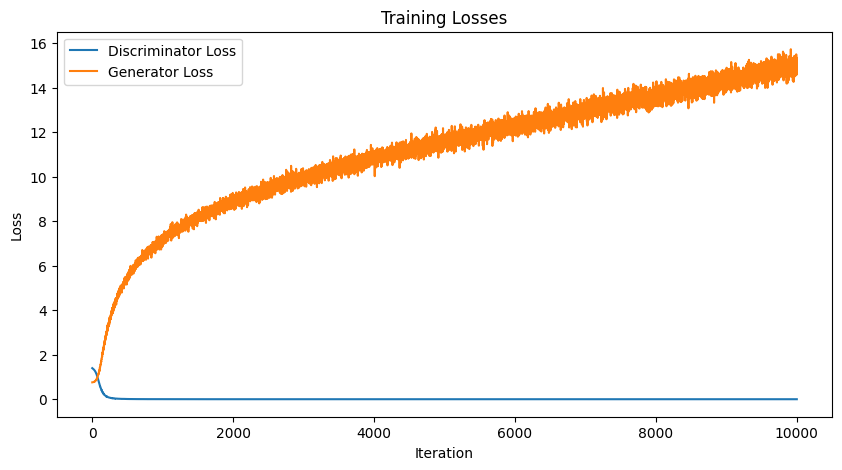

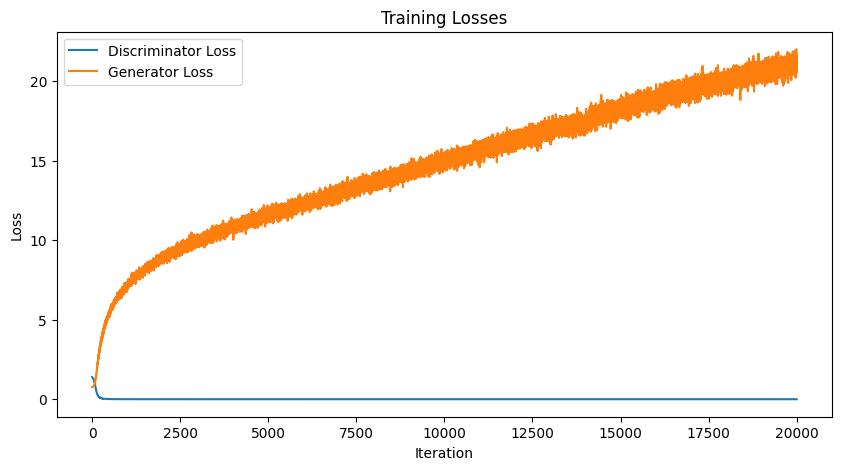

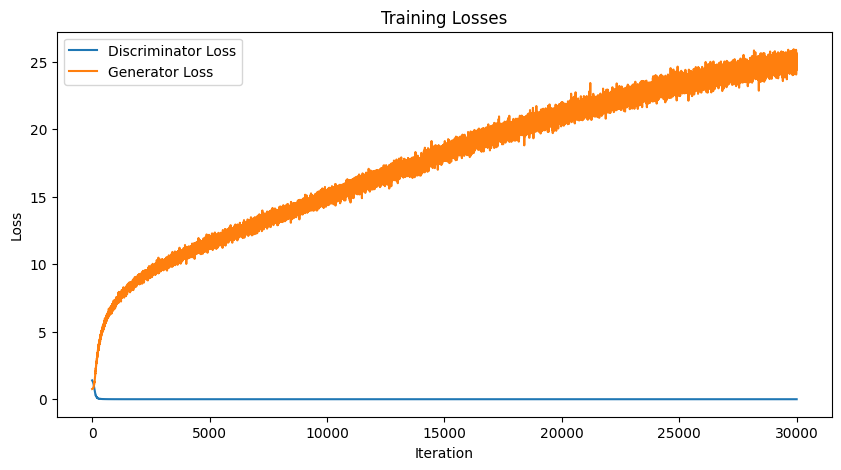

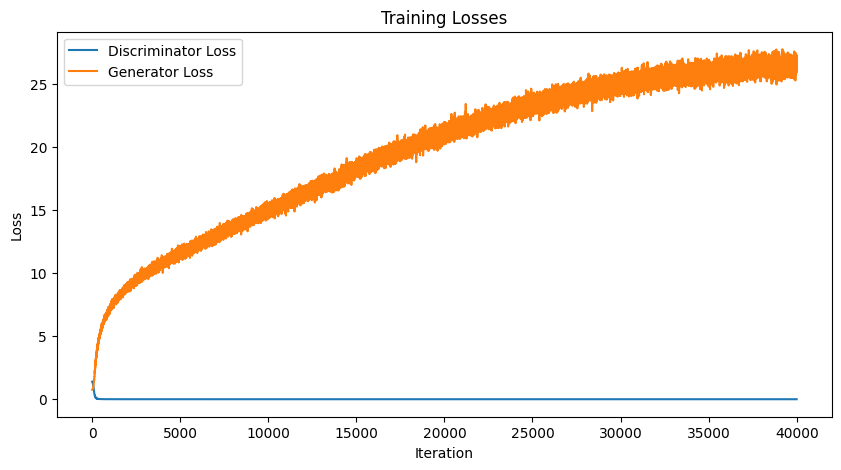

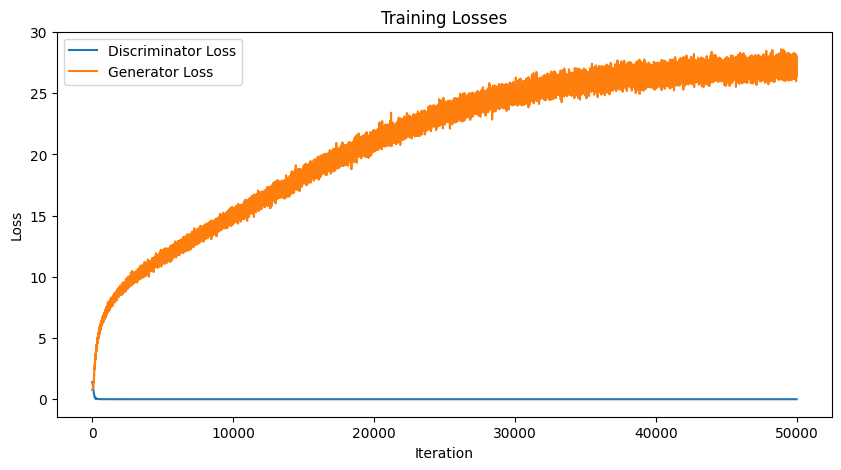

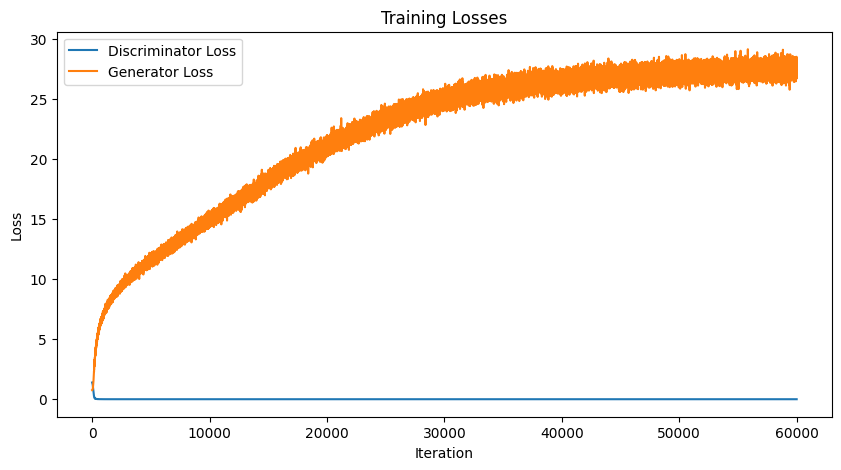

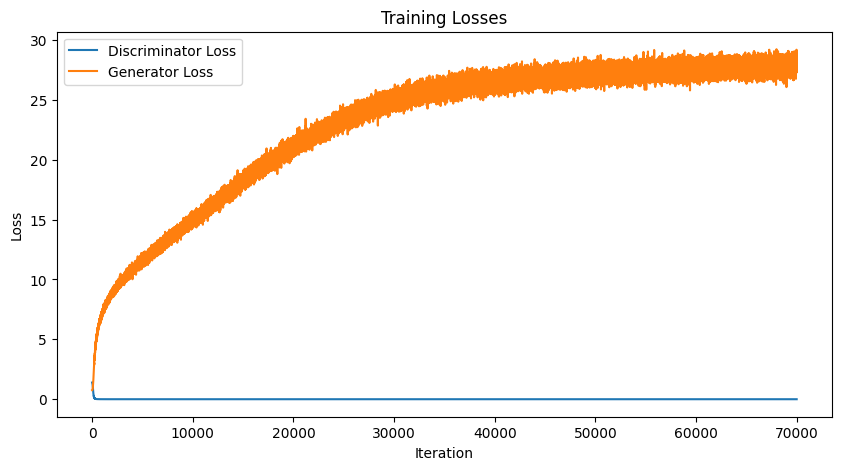

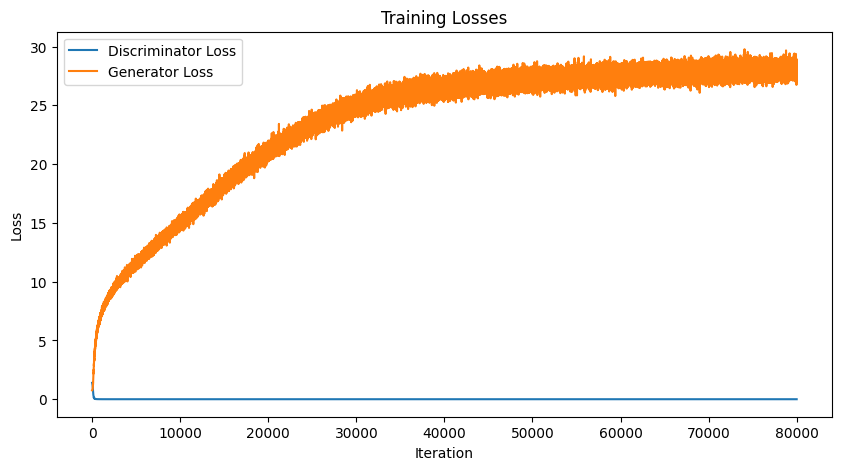

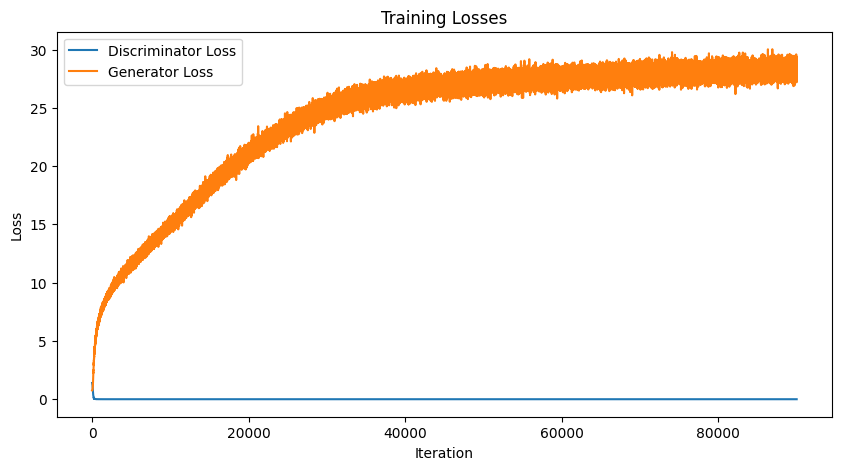

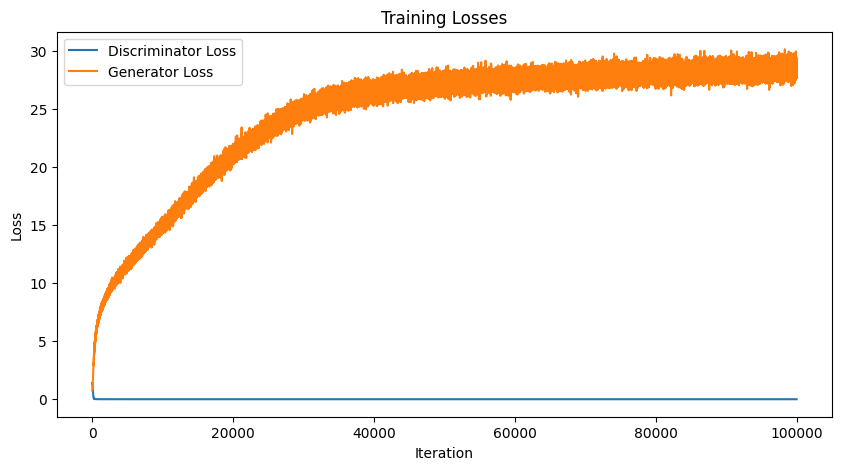

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0258],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0128, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0023],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0099],
        [0.0000, 0.0281, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
=== Training for label: 12, count: 3972 ===
Training for 100000 epochs


KeyboardInterrupt: 

In [18]:
if __name__ == "__main__":
#     args = sys.argv
#     if len(args) != 3:
#         print("Usage: python 004_gan.py <is_train> <is_generate>")
#         sys.exit(1)
#     else:
#         print(f"is_train: {args[1]}, is_generate: {args[2]}")

    TRAIN_PATH = os.path.abspath("data_cicids2017/1_formated/cicids2017_formated_scaled.csv")
    df = pd.read_csv(TRAIN_PATH)

    le = LabelEncoder()
    df["Label"] = le.fit_transform(df["Label"])
    labels = df["Label"].unique()
    class_list = le.classes_
    original_df = df.copy()


    df = df.drop(columns=["Attempted Category"])
    print(df.shape)

    # is_train = input("Train? (y/n): ") if not args[1] else args[1]
    # if is_train == "y":
    for label in labels:
        df_label = df[df["Label"] == label]
        if len(df_label) < MAX_RANGE // 10:
            print(f"=== Training for label: {label}, count: {len(df_label)} ===")
            # continue
            train(df_label)
        else:
            print(f"=== Skipping label: {label}, count: {len(df_label)} ===")

    with open("result/gan/label_list.txt", "w") as f:
        for label in class_list:
            f.write(f"{label}\n")

    # is_generate = input("Generate? (y/n): ") if not args[2] else args[2]
    # if is_generate == "y":
    with open("result/gan/label_list.txt", "r") as f:
        class_list = [line.strip() for line in f.readlines()]

    original_df = original_df[original_df["Attempted Category"] == -1]

    gen_hidden_size = 100

    result_df = pd.DataFrame(
        columns=original_df.columns.tolist()
    )

    for label in original_df["Label"].unique():
        print(f"=== Generating for label: {label}, name: {class_list[label]} ===")
        label_df = original_df[original_df["Label"] == label].drop(columns=["Label", "Attempted Category"])
        data_column_size = len(label_df.columns)
        z_size = data_column_size
        gen_model = GeneratorNetwork(z_size, gen_hidden_size, data_column_size).to(device)

        try:
            gen_model.load_state_dict(torch.load(f"result/gan/gen/gen_model_[{label}].pth"))
        except FileNotFoundError:
            print(f"=== Model not found for label: {label} ===")
            continue
        
        data_size = MAX_RANGE // 10 - len(label_df)
        print(f"+++ Generating {data_size} data for label: {label} +++")
        df = generate_data(gen_model, z_size, data_size, label_df.columns, label)
        result_df = pd.concat([result_df, df])
        print(f"+++ Generated {len(df)} data for label: {label} +++")

    result_df.to_csv("result/gan/generated_data.csv", index=False, chunksize=1_000)